In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
df = pd.read_csv('netflix_dataset.csv')

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [44]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


## Clean Data

In [45]:
df.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [46]:
def analyse_missing_value(df):
    missing_value = df.isnull().sum()
    missing_percentage = (missing_value/len(df))*100
    missing_df = pd.DataFrame({
        'Missing Value': missing_value,
        'Percentage': missing_percentage.round(2)
    })
    print("\nMissing Value Analysis:")
    print(missing_df[missing_df['Missing Value']>0].sort_values('Missing Value', ascending = False))

analyse_missing_value(df)
print("\n=============================================")
print("\nContent Type Distribution:")
print(df['type'].value_counts())


Missing Value Analysis:
            Missing Value  Percentage
director             2634       29.91
country               831        9.44
cast                  825        9.37
date_added             10        0.11
rating                  4        0.05
duration                3        0.03


Content Type Distribution:
type
Movie      6131
TV Show    2676
Name: count, dtype: int64


In [47]:
df['listed_in'] = df['listed_in'].apply(lambda x: ', '.join([genre for genre in x.split(', ') if genre != 'International TV Shows']))
df['listed_in'] = df['listed_in'].apply(lambda x: ', '.join([genre for genre in x.split(', ') if genre != 'International Movies']))

## Exploratory Data Analysis

Text(0, 0.5, 'Cantidad')

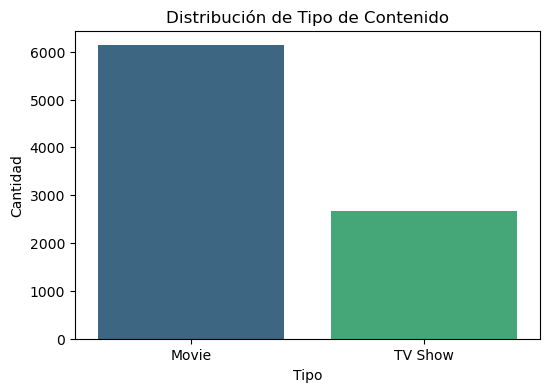

In [48]:
plt.figure(figsize=(6,4))
sns.countplot(x='type', hue='type', data=df, palette='viridis', legend=False)
plt.title('Distribución de Tipo de Contenido')
plt.xlabel('Tipo')
plt.ylabel('Cantidad')

Text(0, 0.5, 'Cantidad de Estrenos')

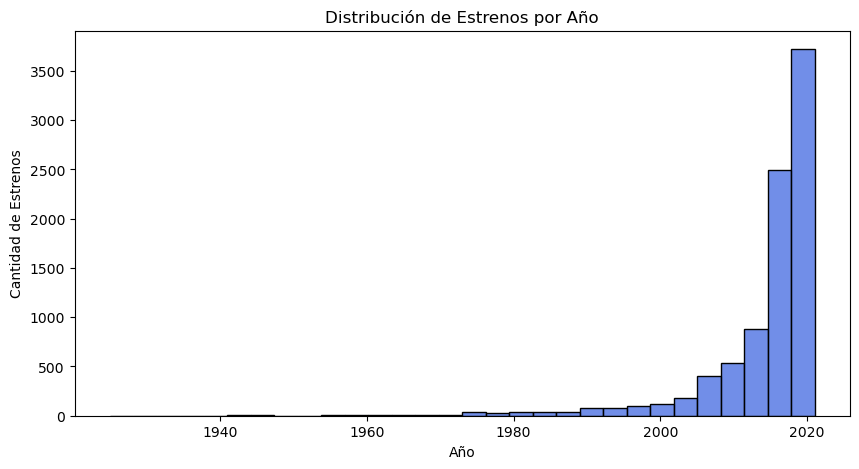

In [49]:
plt.figure(figsize=(10,5))
sns.histplot(df['release_year'], bins=30, color='royalblue')
plt.title('Distribución de Estrenos por Año')
plt.xlabel('Año')
plt.ylabel('Cantidad de Estrenos')

Text(0, 0.5, 'País')

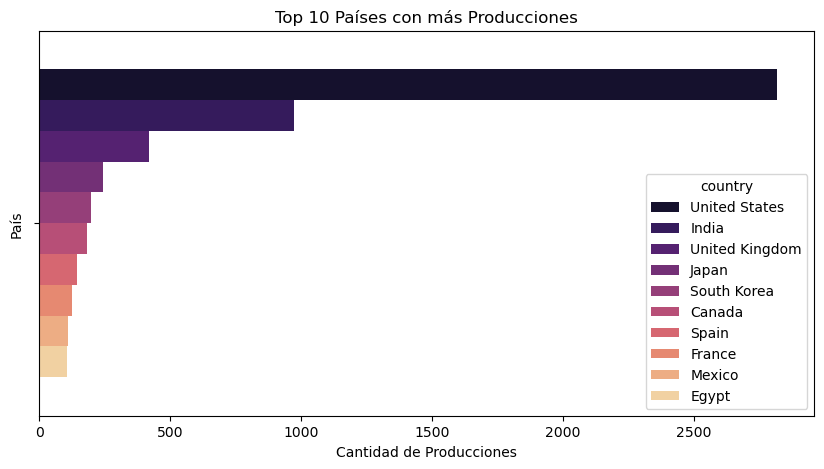

In [50]:
top_countries = df['country'].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_countries.values, hue=top_countries.index, palette='magma')
plt.title('Top 10 Países con más Producciones')
plt.xlabel('Cantidad de Producciones')
plt.ylabel('País')

Text(0.5, 1.0, 'Top 10 Géneros')

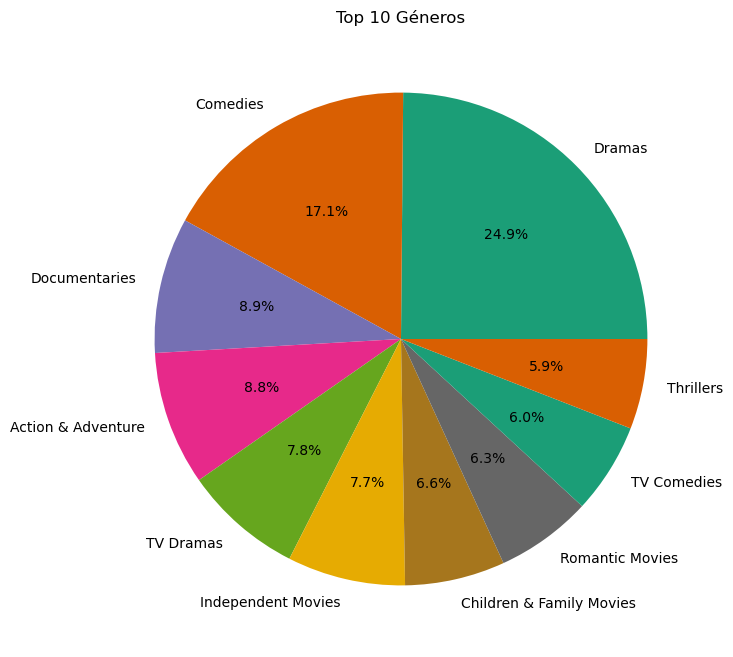

In [51]:
genres = df['listed_in'].str.split(', ').explode()
top_genres = genres.value_counts().head(10)

plt.figure(figsize=(8, 8))
plt.pie(top_genres, labels=top_genres.index, autopct='%1.1f%%', colors=sns.color_palette('Dark2', len(top_genres)))
plt.title('Top 10 Géneros')

In [52]:
df.shape

(8807, 12)

In [53]:
def analyse_missing_value(df):
    missing_value = df.isnull().sum()
    missing_percentage = (missing_value/len(df))*100
    missing_df = pd.DataFrame({
        'Missing Value': missing_value,
        'Percentage': missing_percentage.round(2)
    })
    print("\nMissing Value Analysis:")
    print(missing_df[missing_df['Missing Value']>0].sort_values('Missing Value', ascending = False))

analyse_missing_value(df)
print("\n=============================================")
print("\nContent Type Distribution:")
print(df['type'].value_counts())


Missing Value Analysis:
            Missing Value  Percentage
director             2634       29.91
country               831        9.44
cast                  825        9.37
date_added             10        0.11
rating                  4        0.05
duration                3        0.03


Content Type Distribution:
type
Movie      6131
TV Show    2676
Name: count, dtype: int64


In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
import re
from sklearn.preprocessing import MinMaxScaler
from sentence_transformers import SentenceTransformer
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import tensorflow as tf
import tensorflow_hub as hub
from scipy.sparse import hstack

In [55]:
# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /Users/ferp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ferp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/ferp/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [98]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

class AdvancedNetflixRecommender:
    def __init__(self, df):
        self.df = df.copy()
        
        # Fill NaNs
        self.df['description'] = self.df['description'].fillna('')
        self.df['listed_in'] = self.df['listed_in'].fillna('')
        self.df['cast'] = self.df['cast'].fillna('')
        self.df['director'] = self.df['director'].fillna('')

        # Concatenate description + genre
        self.df['text_for_bert'] = self.df.apply(
            lambda row: row['description'] + " Genre: " + row['listed_in'], axis=1
        )

        # Load BERT model
        self.bert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

        # Compute BERT embeddings
        self.description_embeddings = self.bert_model.encode(
            self.df['text_for_bert'].tolist(), show_progress_bar=True
        )

        # TF-IDF on genres (optional)
        self.tfidf = TfidfVectorizer(stop_words='english')
        self.genre_matrix = self.tfidf.fit_transform(self.df['listed_in'])

    def get_description_similarity(self, idx):
        """Similarity based on BERT embeddings"""
        return cosine_similarity(
            self.description_embeddings[idx].reshape(1, -1),
            self.description_embeddings
        ).flatten()

    def get_genre_similarity(self, idx):
        """Similarity based on TF-IDF genre"""
        return cosine_similarity(
            self.genre_matrix[idx],
            self.genre_matrix
        ).flatten()

    def get_recommendations(self, title, n_recommendations=5, weights=None, filter_type=None, filter_genre=None):
        if weights is None:
            weights = {
                'description': 0.8,
                'genre': 0.2
            }

        if title not in self.df['title'].values:
            return f"Title '{title}' not found in dataset."

        idx = self.df[self.df['title'] == title].index[0]

        # Get similarity scores
        desc_sim = self.get_description_similarity(idx)
        genre_sim = self.get_genre_similarity(idx)

        # Weighted combination
        combined_similarity = (
            weights['description'] * desc_sim +
            weights['genre'] * genre_sim
        )

        # Get indices of most similar items (excluding itself)
        similar_indices = combined_similarity.argsort()[::-1]
        similar_indices = [i for i in similar_indices if i != idx]

        # Filter by type or genre if specified
        filtered = []
        for i in similar_indices:
            row = self.df.iloc[i]
            if filter_type and row['type'] != filter_type:
                continue
            if filter_genre and filter_genre not in row['listed_in']:
                continue
            filtered.append({
                'title': row['title'],
                'type': row['type'],
                'genre': row['listed_in'],
                'description': row['description'],
                'similarity_score': combined_similarity[i]
            })
            if len(filtered) >= n_recommendations:
                break

        return filtered


In [ ]:
recommender = AdvancedNetflixRecommender(df)

Batches:   0%|          | 0/276 [00:00<?, ?it/s]

In [111]:
def print_recommendations(title, recs):
    print(f"Getting recommendations for '{title}'...\n")
    for i, rec in enumerate(recs, 1):
        print(f"{i}. {rec['title']}")
        print(f"Type: {rec['type']}")
        print(f"Genre: {rec['genre']}")
        # print(f"Description: {rec['description']}")
        # print(f"Similarity score: {rec['similarity_score']:.4f}")
        # print(f"Cluster: {rec.get('cluster', 'N/A')}\n")
        print()


In [112]:
title = 'Dark'
results = recommender.get_recommendations(title, n_recommendations=5)
print_recommendations(title, results)

Getting recommendations for 'Dark'...

1. Better Than Us
Type: TV Show
Genre: Crime TV Shows, TV Dramas

2. Entangled
Type: TV Show
Genre: TV Dramas

3. Ultraviolet
Type: TV Show
Genre: Crime TV Shows, TV Dramas

4. The Good Detective
Type: TV Show
Genre: Crime TV Shows, TV Dramas

5. 20 Minutes
Type: TV Show
Genre: Crime TV Shows, TV Dramas

